<a href="https://colab.research.google.com/github/kaylay18/Effluent-Concentration-Prediction/blob/main/Effluent_Wastewater_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import shap
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Integer
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

In [4]:
# Load the dataset
file_name = 'Wastewater Effluent Dataset.xlsx'
df = pd.read_excel(file_name)
df.head()

,COD_eff,EC_eff,Q_in,Zn_in,pH_in,BOD_in,COD_in,TSS_in,VSS_in,EC_in
0,84.0,2000,44101.0,1.5,7.8,NaN,407.0,166.0,66.3,2110
1,91.0,2590,39024.0,3.0,7.7,NaN,443.0,214.0,69.2,2660
2,128.0,1888,32229.0,5.0,7.6,NaN,528.0,186.0,69.9,1666
3,104.0,1840,35023.0,3.5,7.9,205.0,588.0,192.0,65.6,2430
4,108.0,2120,36924.0,1.5,8.0,242.0,496.0,176.0,64.8,2110


In [5]:
# Check for missing data
missing_data = df.isnull().sum()

# Print the results
print(missing_data)

COD_eff    32
EC_eff      0
Q_in       18
Zn_in       3
pH_in       0
BOD_in     23
COD_in      6
TSS_in      1
VSS_in     11
EC_in       0
dtype: int64


In [6]:
# Fill missing values with the mean of each column
for column in df.columns:
    if df[column].isnull().any():  # Check if column has missing values
        mean_value = df[column].mean()  # Calculate mean of the column
        df[column].fillna(mean_value, inplace=True)  # Fill missing values with the mean

# Verify if there are any missing values left
print(df.isnull().sum())

COD_eff    0
EC_eff     0
Q_in       0
Zn_in      0
pH_in      0
BOD_in     0
COD_in     0
TSS_in     0
VSS_in     0
EC_in      0
dtype: int64


<ipython-input-6-fde15dac4ab8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)  # Fill missing values with the mean


In [7]:
# Calculate the IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# Remove outliers
df_cleaned = df[~outliers.any(axis=1)]

In [8]:
df_cleaned.describe()

,COD_eff,EC_eff,Q_in,Zn_in,pH_in,BOD_in,COD_in,TSS_in,VSS_in,EC_in
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,81.260083,1456.443609,37106.902966,1.814339,7.808271,181.687504,394.370831,193.507454,64.196722,1446.080201
std,23.415348,308.741799,5886.182568,1.397950,0.241346,50.550832,99.729495,44.367235,9.255170,335.594782
min,23.000000,828.000000,24978.000000,0.100000,7.200000,58.000000,126.000000,98.000000,36.100000,810.000000
25%,65.000000,1231.500000,32964.000000,0.800000,7.600000,146.500000,321.000000,166.000000,58.550000,1199.000000
50%,82.823887,1431.000000,36162.000000,1.400000,7.800000,181.000000,393.000000,188.000000,65.200000,1402.000000
75%,96.500000,1668.500000,40919.000000,2.500000,8.000000,215.000000,464.000000,220.000000,70.800000,1652.000000
max,147.000000,2300.000000,53210.000000,6.000000,8.400000,330.000000,688.000000,328.000000,85.000000,2370.000000


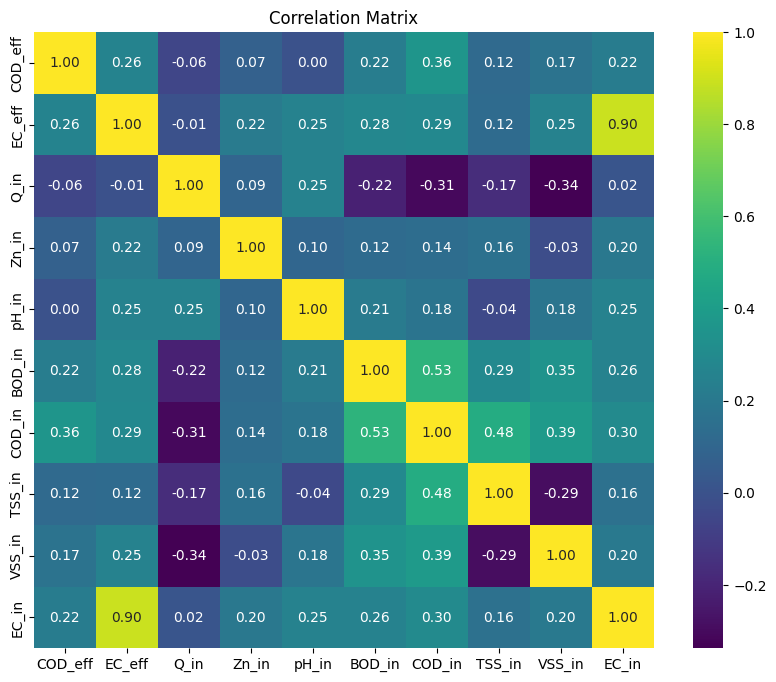

In [9]:
# Calculate the correlation matrix
correlation_matrix = df_cleaned.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [10]:
!pip install deon

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for deon: filename=deon-0.3.0-py3-none-any.whl size=21350 sha256=526c82be15ed6fbb3781ac0c6c54a5817ff3be76294039e289f6839163923dd4
  Stored in directory: /root/.cache/pip/wheels/65/8e/b0/6215389003a488515cb8287265bc54506a636bbf043d79c2b8
Successfully built deon


In [13]:
# Generate the checklist using the Deon CLI in markdown format
!deon --output wastewater_effluent_ethics_checklist.md --format markdown

Checklist successfully written to file wastewater_effluent_ethics_checklist.md.


In [14]:
# Read and display the generated checklist
with open('wastewater_effluent_ethics_checklist.md', 'r') as file:
    checklist_content = file.read()

print(checklist_content)

# Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?
 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?
 - [ ] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

## B. Data Storage


In [15]:
# Splitting the dataset into training and test sets
columns_to_drop = [col for col in df_cleaned.columns if 'EC_eff' in col]
X = df_cleaned.drop(columns=columns_to_drop, axis=1)
y = df_cleaned['EC_eff']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Machine Learning Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Training and evaluating the models
best_model = None
best_rmse = float('inf')

for model_name, model in models.items():
    print(f"Training {model_name}...")

    if model_name in ["SVM", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Print the metrics for the current model
    print(f"{model_name} Metrics:")
    print(f"  RMSE: {rmse_test:.4f}")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  R^2: {r2_test:.4f}")

    # Save the best model based on RMSE for the test dataset
    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = model
        best_model_name = model_name

    print(f"{model_name} RMSE on Test Data: {rmse_test}")

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model: {best_model_name} with RMSE: {best_rmse}")

Training Random Forest...
Random Forest Metrics:
  RMSE: 302.5030
  MAE: 214.3125
  R^2: 0.0793
Random Forest RMSE on Test Data: 302.50295453102603
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics:
  RMSE: 256.6678
  MAE: 183.1500
  R^2: 0.3372
Logistic Regression RMSE on Test Data: 256.66778138286077
Training Decision Tree...
Decision Tree Metrics:
  RMSE: 188.6780
  MAE: 140.2250
  R^2: 0.6418
Decision Tree RMSE on Test Data: 188.67796638717516
Training SVM...
SVM Metrics:
  RMSE: 246.1957
  MAE: 191.0375
  R^2: 0.3901
SVM RMSE on Test Data: 246.19573006045414
Training KNN...
KNN Metrics:
  RMSE: 187.3572
  MAE: 151.9750
  R^2: 0.6468
KNN RMSE on Test Data: 187.35723097868416
Best model: KNN with RMSE: 187.35723097868416


In [16]:
# 1. Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(KNeighborsRegressor(),
                           param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# 2. Random Search
param_dist = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

random_search = RandomizedSearchCV(KNeighborsRegressor(),
                                   param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5)
random_search.fit(X_train, y_train)

# 3. Bayesian Optimization
search_spaces = {
    'n_neighbors': (1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

bayes_search = RandomizedSearchCV(KNeighborsRegressor(),
                             search_spaces, n_iter=10, scoring='neg_mean_squared_error', cv=5)
bayes_search.fit(X_train, y_train)

# Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, r2, mae

# Evaluate each method
for model_name, model in [('Grid Search', grid_search.best_estimator_),
                         ('Random Search', random_search.best_estimator_),
                         ('Bayesian Optimization', bayes_search.best_estimator_)]:
    rmse, r2, mae = evaluate_model(model, X_test, y_test)
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R^2: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")

results = {}
for model_name, model in [('Grid Search', grid_search.best_estimator_),
                         ('Random Search', random_search.best_estimator_),
                         ('Bayesian Optimization', bayes_search.best_estimator_)]:
    rmse, r2, mae = evaluate_model(model, X_test, y_test)
    results[model_name] = {'RMSE': rmse, 'R^2': r2, 'MAE': mae}

# Find the best method based on lowest RMSE
best_method = min(results, key=lambda k: results[k]['RMSE'])

# Print the best method
print(f"The best hyperparameter tuning method is: {best_method}")
print(f"with RMSE: {results[best_method]['RMSE']:.4f}, "
      f"R^2: {results[best_method]['R^2']:.4f}, "
      f"and MAE: {results[best_method]['MAE']:.4f}")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Grid Search:
  RMSE: 183.6592
  R^2: 0.6606
  MAE: 142.7459
Random Search:
  RMSE: 192.2456
  R^2: 0.6281
  MAE: 151.3667
Bayesian Optimization:
  RMSE: 231.0012
  R^2: 0.4631
  MAE: 172.6125
The best hyperparameter tuning method is: Grid Search
with RMSE: 183.6592, R^2: 0.6606, and MAE: 142.7459


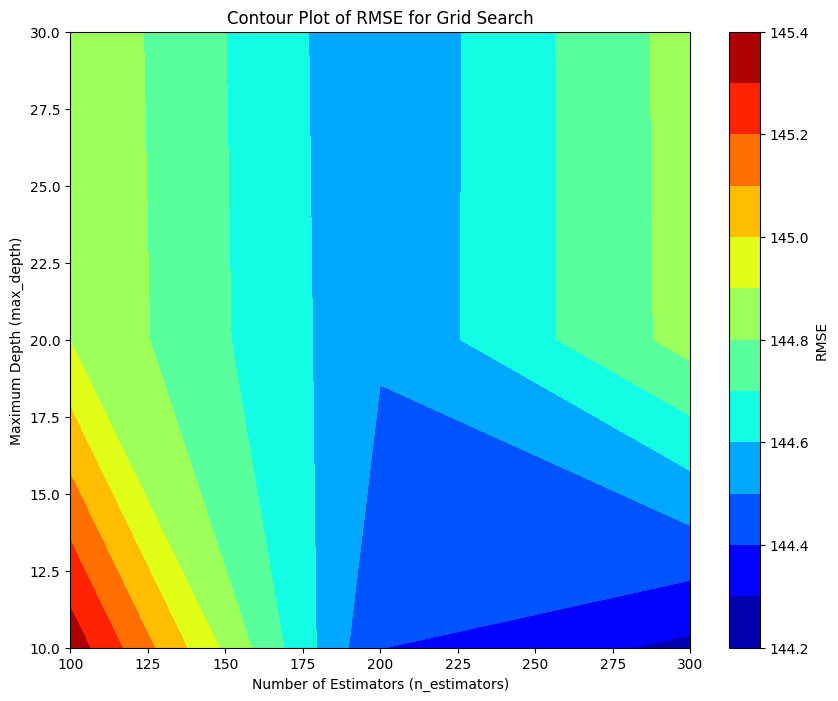

In [17]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,  # Use all available cores for parallel processing
    return_train_score=True
)

grid_search.fit(X_train, y_train)

results = grid_search.cv_results_

# Create a meshgrid of hyperparameter values
n_estimators_values = param_grid['n_estimators']
max_depth_values = param_grid['max_depth']
N_ESTIMATORS, MAX_DEPTH = np.meshgrid(n_estimators_values, max_depth_values)

# Calculate RMSE for each point on the meshgrid
rmse_values = np.zeros_like(N_ESTIMATORS, dtype=float)
for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        mask = (results['param_n_estimators'] == n_estimators) & (results['param_max_depth'] == max_depth)
        rmse_values[j, i] = np.sqrt(-results['mean_test_score'][mask][0])

# Create the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(N_ESTIMATORS, MAX_DEPTH, rmse_values, levels=10, cmap='jet')
plt.xlim(100, 300)  # Set x-axis limits
plt.ylim(10, 30)    # Set y-axis limits
plt.colorbar(contour, label='RMSE')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Maximum Depth (max_depth)')
plt.title('Contour Plot of RMSE for Grid Search')
plt.show()

  0%|          | 0/319 [00:00<?, ?it/s]

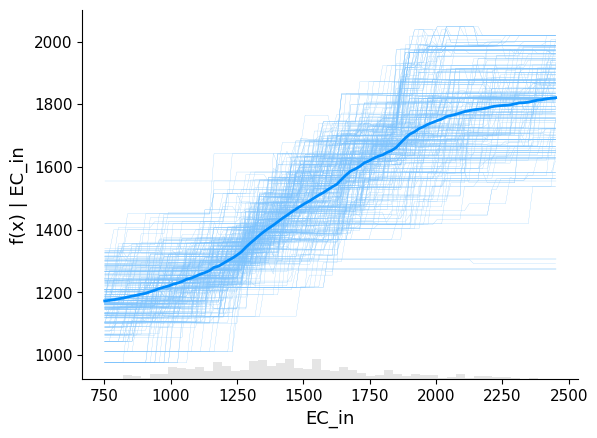

In [18]:
# Partial Dependence Plot
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.KernelExplainer(knn_model.predict, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot the PDP
shap.partial_dependence_plot(
    "EC_in", knn_model.predict, X_train
)

  0%|          | 0/80 [00:00<?, ?it/s]

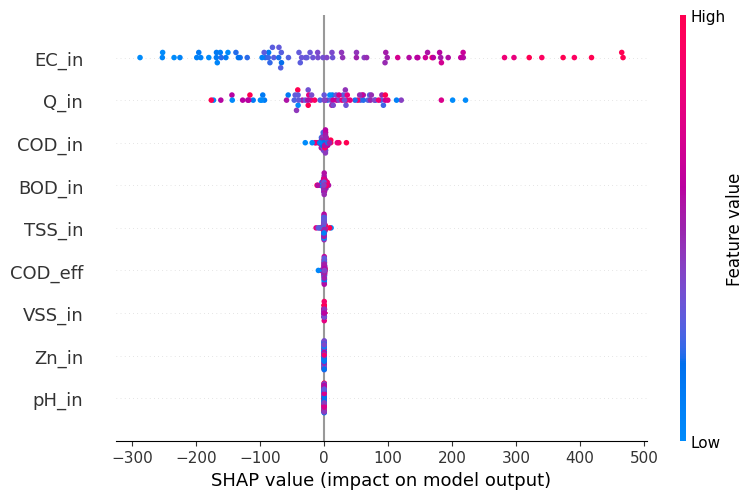

In [19]:
# Beeswarm Plot
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_train[:100])

# Calculate SHAP values for a subset of data
shap_values = explainer.shap_values(X_test[:100])

# Create a beeswarm plot
shap.summary_plot(shap_values, X_test[:100])

In [20]:
# Title of the app
st.title("Wastewater Effluent Concentration Prediction")

influent_flowrate = st.number_input("Enter the influent Flowrate (L/h):", value=40000)
influent_zinc = st.number_input("Enter concentration of zinc in the influent (%):", min_value=0, max_value=100, value=0)
influent_ph = st.number_input("Enter pH of the influent:", min_value=0, max_value=14, value=7)
influent_BOD = st.number_input("Enter influent Biochemical Oxygen Demand (mg/L):", value=350)
influent_COD = st.number_input("Enter influent Chemical Oxygen Demand (mg/L):", value=350)
influent_TSS = st.number_input("Enter Total Suspended Solids in influent (mg/L)", value=100)
influent_VSS = st.number_input("Enter Volitile Suspended Solids in influent (mg/L):", value=50)
influent_EC = st.number_input("Enter influent Electrical Conductivity (S/m):", value=2000)

# Encoding the inputs
input_data = pd.DataFrame({
    'Q_in': [influent_flowrate],
    'Zn_in': [influent_zinc],
    'pH_in': [influent_ph],
    'BOD_in': [influent_BOD],
    'COD_in': [influent_COD],
    'TSS_in': [influent_TSS],
    'VSS_in': [influent_VSS],
    'EC_in': [influent_EC]

})

# One-hot encode the input data
input_encoded = pd.get_dummies(input_data)

# Align columns with the training data
required_columns = model.feature_names_in_
for col in required_columns:
    if col not in input_encoded.columns:
        input_encoded[col] = 0
input_encoded = input_encoded[required_columns]

# Make the prediction
prediction = model.predict(input_encoded)[0]

# Display the prediction
st.subheader(f"Electrical Coductivity of the Effluent: {prediction}")

# Deon's Checklist
st.markdown(checklist_content)

# Ethics Data Card
datacard_content = """
# Ethics DataCard for Wastewater Effluent Concentration Prediction Model

## Dataset Overview
- **Input Variables**: Influent Flowrate, zinc, pH, BOD, COD, TSS, VSS, EC
- **Output Variables**: Effluent COD and EC

## Data Collection Process
- Data source collected from Manresa Wastewater Treatment Plant in Barcelona
- Data is collected from public and licensed sources, ensuring proper consent and anonymization of any private information (e.g., personal property location).

## Bias Considerations
- **Potential Bias**: Data source based on one water treatment location so there may be limited representation that does not reflect the diversity of conditions at other wastewater treatment plants.
- **Mitigation**: The model utlizes universal features such as pH and flowrate that are likely consistent across different wastewater treatment plants and is trained to avoid overly specific features that are unique to this specific plant.

## Fairness & Justice
- The model has been trained to predict wastewater effluent concentration based on universal features. Efforts have been made to avoid disproportionate impacts (releasing unsafe water) on vulnerable communities (e.g., rural populations, indigenous lands).
- Special attention is given to reducing false indication of safe electrical conductivity level, balancing the risk for all stakeholders.

## Privacy and Security
- Data collected from Manresa Wastewater Treatment Plant does not contain information that identifies workers.
- No social media or surveillance data is used at all.
- Data source only contains data about influent and effluent wastewater.

## Sustainability and Environmental Impact
- The model aims to evaluate and improve the quality of water in order to preserve the surrounding environment and protect public health.
- It supports long-term environmental sustainability by supporting a circular economy that encourages and optimizes water reuse.

## Model Limitations
- The model's accuracy is limited to the Manresa Wastewater Treatment Plant.
- There are limitations to predicting the effluent concentration of other plants with this model due to plant uniqueness from utilizing different features.
- The model is continuously monitored and tries to utilize universal features in order to be used at other treatment plants.

## Accountability and Transparency
- The development team will monitor the model for performance over time, ensuring that it adapts to new data.
- Stakeholders (e.g., environmental agencies, local governments) will be informed of the model’s limitations, ensuring proper interpretation of the predictions.
- False predictions will be communicated to stakeholders, with a process in place for continuous feedback and model improvement.

## Societal Impact
- The model is designed to protect both human lives and the environment by enabling better resourse allocation to ensure safe water release back into the environment
- It has the potential to inform policy changes in land management, conservation, and public health strategies.
"""
st.markdown(datacard_content)

2024-11-26 18:11:26.046 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.141 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-26 18:11:26.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.152 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 18:11:26.156 Session state does not 

DeltaGenerator()